# Student Thesis Supervisor Matching

The problem to solve is matching student preferences to available supervisor slots. At the same time, each supervisor should have an equal number of students and each student should get their highest preference topic. 

In [138]:
%pip install networkx
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Data loading

Please provide the three csv files with your own data. There are sample files in the repository.

In [ ]:
import pandas as pd

df_supervisors = pd.read_csv('supervisor_details.tsv', encoding='utf-8',  sep='\t',index_col=0)
df_topics = pd.read_csv('student_choices.tsv', encoding='utf-8', sep='\t',index_col=0)
df_students = pd.read_csv('thesis_topics_by_supervisor.tsv', encoding='utf-8', sep='\t',index_col=0)

## Class generation

There are three classes to run this probabilistic simulation, a supervisor, a student and a topic.

In [140]:
class Supervisor:
    def __init__(self, id, name, titled, role, affiliation, profile, capacity):
        self.id = id
        self.name = name
        self.titled = titled
        self.role = role
        self.affiliation = affiliation
        self.profile = profile
        self.capacity = capacity
        self.topics = []
        self.cotopics = []
        self.assigned_students = []
        self.cosupervised_students = []
        self.reveal = False

    def student_load(self):
        return len(self.assigned_students) + len(self.cosupervised_students)

    def __repr__(self):
        
        return str(self.name)

class Student:
    def __init__(self, id, name):
        self.id = id
        self.name = name
        self.preferences = []
        self.topic = None
        self.attained_preference = -1

    def assign_topic(self, topic, preference):
        self.topic = topic
        self.topic.supervisor.assigned_students.append(self)
        if self.topic.cosupervisor:
            self.topic.cosupervisor.cosupervised_students.append(self)
        self.attained_preference = preference
        self.topic.final_students.append(self)
    
    def __repr__(self):
        return str(self.name)


class Topic:
    def __init__(self, id, name, supervisor, cosupervisor,capacity):
        self.id = id
        self.name = name
        self.supervisor = supervisor
        self.cosupervisor = cosupervisor
        self.interested_students = {
            1:[],
            2:[],
            3:[]
        }
        self.final_students = []
        self.capacity = capacity

    def is_available(self):
        return len(self.final_students)<self.capacity and \
               self.supervisor.capacity > self.supervisor.student_load() and \
               (not self.cosupervisor or \
               self.cosupervisor.capacity > self.cosupervisor.student_load())

    def add_student_interest(self, student, preference):
        if (preference == 1 or preference == 2 or preference == 3):
            self.interested_students[preference].append(student)
        else:
            print("Not a valid preference: " + str(preference))
    
    def __repr__(self):
        return str(self.name)


A reset function allows to recreate the baseline students, supervisors and topics without assignment links.

In [ ]:
students = {}
supervisors = {}
topics = {}
def reset_all(students,supervisors,topics):
    #students = {i:Student(i, name = "Student 1 %2d" % (i)) for i in range(0,len(preferences))}
    students = {i:Student(i, name = df_students.iloc[i].loc["Name"]) for i in range(0,len(df_students))}
    
    supervisors = {df_supervisors.iloc[i,5]:Supervisor(i,
                                df_supervisors.iloc[i,1],
                                df_supervisors.iloc[i,2],
                                df_supervisors.iloc[i,3],
                                df_supervisors.iloc[i,4],
                                df_supervisors.iloc[i,5],
                                df_supervisors.iloc[i,6]) for i in range(0,len(df_supervisors))}

    topics = {df_topics.iloc[i,1].strip():Topic(i,
                      df_topics.iloc[i,1].strip(),
                      supervisors[df_topics.iloc[i,2]],
                      (supervisors[df_topics.iloc[i,3]] if not isinstance(df_topics.iloc[i,3], float) else None),
                      df_topics.iloc[i,5]) for i in range(0,len(df_topics))}
    
    for (i, student) in students.items():
        for j in range(4,7):
            #student.preferences.append(topics[preferences[i][j]-1])
            #print(i)
            #print(j)
            #print(df_students.iloc[i,j])
            student.preferences.append(topics[df_students.iloc[i,j].strip()])
            
            topics[df_students.iloc[i,j].strip()].add_student_interest(student,j-3)

    
    for (i, topic) in topics.items():
        topic.supervisor.topics.append(topic)
        if topic.cosupervisor:
            topic.cosupervisor.cotopics.append(topic)

    return (students,supervisors,topics)

students, supervisors, topics =reset_all(students,supervisors,topics)

## Visualisation

A network visualisation of the relations between supervisors, topics and students. Topics are linked to the supervisor and students are linked to all topics in their preference list.

[]


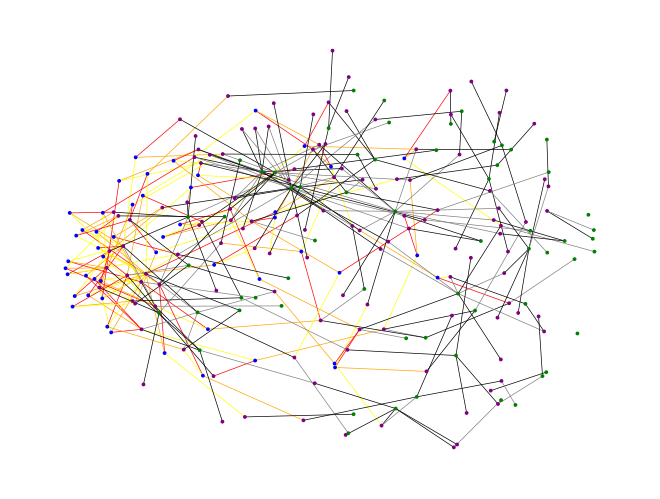

In [168]:
import networkx as nx
import matplotlib.pyplot as plt


G=nx.Graph()

start_supervisors = len(students)
start_topics = len(students) + len(supervisors)

G.add_nodes_from(students.values(),name='0student')
G.add_nodes_from(supervisors.values(),name='2supervisor')
G.add_nodes_from(topics.values(),name='1topic')

print(G.edges)

for (i,student) in students.items():
    j=1
    for (topic) in student.preferences:
        if j==1:
            G.add_edge(student,topic,weight=1,color="red", preference= j)
        elif j==2:
            G.add_edge(student,topic,weight=1,color="orange", preference= j)
        else:
            G.add_edge(student,topic,weight=1,color="yellow", preference= j)
        j = j + 1


for (i,topic) in topics.items():
    G.add_edge(topic,topic.supervisor,weight=1,color="black", object= topic)
    if topic.cosupervisor:
        G.add_edge(topic,topic.cosupervisor,weight=1,color="grey", object= topic)

color_map = []
for node in G:
    if type(node) is Student:
        color_map.append('blue')
    elif type(node) is Supervisor:
        color_map.append('green')
    else: 
        color_map.append('purple')    

pos = nx.multipartite_layout(G, subset_key="name")
#pos = nx.circular_layout(G)
pos = nx.spring_layout(G,k=0.5,pos=pos)
G_all = G
nx.draw(G_all, pos, node_color=color_map,edge_color=nx.get_edge_attributes(G_all,'color').values(),width=0.5,node_size=3)

## Naive implementation

The naive implementation tries to assign all students in a random order for n-iterations according to the rules:

- Students are offered the highest preference that is still available
- A topic is still available if the topic has capacity, the supervisor has capcity and if existing the cosupervisor has capacity

The best runs are kept to produce distribution statistics.

In [182]:
iter_data = iter_data2

In [169]:
def try_assign_topic(student, topic, preference):
    if topic.is_available():
        if debug:
            print("Student " + student.name + " assigned topic " + str(topic.name))
        student.assign_topic(topic,preference)

In [171]:
import random
import sys
from collections import Counter

#TO BE SET BY USER
seed = 20240619170700
highest_accepted_fails = 3
max_iter = 1000000

#VARIABLES USED BY ALGORITHM
len_stud = len(students)
random.seed(seed)
iter_data = {}
fails = -1
min_fail = sys.maxsize
iter = 0
debug = False
while(iter<max_iter):
    if iter%10000==0:
        print(str((iter/max_iter) * 100)+ "% complete")
    while (fails<min_fail and iter<max_iter):
        
        if iter%1000==0:
            print(iter)
        students, supervisors, topics =reset_all(students,supervisors,topics)
        fails = 0
        
        assignment_order = [random.sample(range(0, len_stud), len_stud)]

        #Randomly select student order to assign prefered topic
        for assignment in assignment_order[0]:
            #print(assignment)
            student = students[assignment]
            pref_assignments = student.preferences#[x-1 for x in preferences[assignment]]
     
            #Is first choice available?
            pref_1 = pref_assignments[0]
            try_assign_topic(student, pref_1, 1)

            #Student didn't get first choice:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_1.name) + " as first preference")
                #Is second choice available?
                pref_2 = pref_assignments[1]
                try_assign_topic(student, pref_2, 2)
            
            #Student didn't get first or second choice:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_2.name) + " as second preference")
                pref_3 = pref_assignments[2]
                try_assign_topic(student, pref_3, 3)

            #Student was left without topic assignemnt:
            if not student.topic:
                if debug:
                    print("Cannot assign topic " + str(pref_3.name) + " as third preference")
                    print("Failed " + student.name)
                fails = fails + 1

        if fails<= highest_accepted_fails:
            print("Student's without supervisor: " + str(fails))
            print("min: " + str(min_fail))
            
            print(Counter([student.attained_preference for student in students.values()]))
            if min(student.attained_preference for student in students.values())<0:
                print("Critical failure OMG")

            if not fails in iter_data:
                iter_data[fails] = {}
            iter_data[fails][iter] = {'sap':sum(student.attained_preference for student in students.values())/len(students),
                               'saw':sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors),
                               'students':students,
                               'supervisors':supervisors,
                               'iteration':iter,
                               'topics':topics,
                               'fails':fails,
                               'minfails':min_fail,
                               'seed':seed}
            min_fail=fails
        
        if debug:
            print("completed iter " + str(iter))
        iter = iter + 1

    if fails<=min_fail:
        print("Average 1st pref. prob.: " + str(sum(1 if student.attained_preference==1 else 0 for student in students.values())/(len_stud)))
        print("Average 2nd pref. prob.: " + str(sum(1 if student.attained_preference==2 else 0 for student in students.values())/(len_stud)))
        print("Average 3nd pref. prob.: " + str(sum(1 if student.attained_preference==3 else 0 for student in students.values())/(len_stud)))
        print("Student average preference: " + str(sum(student.attained_preference if student.attained_preference >0 else 0 for student in students.values())/(len_stud-fails)))
        print("Supervisor average workload: " + str(sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len_stud))
        print("completed iter " + str(iter))
    fails=-1

0.0% complete
0
1000
2000
3000
4000
5000
6000
Student's without supervisor: 3
min: 9223372036854775807
Counter({1: 31, 3: 8, 2: 7, -1: 3})
Critical failure OMG
Average 1st pref. prob.: 0.6326530612244898
Average 2nd pref. prob.: 0.14285714285714285
Average 3nd pref. prob.: 0.16326530612244897
Student average preference: 1.5
Supervisor average workload: 0.573469387755102
completed iter 6690
7000
8000
9000
Student's without supervisor: 3
min: 3
Counter({1: 31, 2: 8, 3: 7, -1: 3})
Critical failure OMG
Average 1st pref. prob.: 0.6326530612244898
Average 2nd pref. prob.: 0.16326530612244897
Average 3nd pref. prob.: 0.14285714285714285
Student average preference: 1.4782608695652173
Supervisor average workload: 0.5612244897959183
completed iter 9166
1.0% complete
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
2.0% complete
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
3.0% complete
30000
31000
Student's without supervisor: 3
min: 3
Counter({1: 28, 2: 9, 3: 9, -1: 3}

### Results

Extract the best run and show some statistics.

In [184]:
import numpy as np

lowest_fail = min(iter_data.keys())
print(lowest_fail)

best_run = np.argmin([run['sap'] for key,run in iter_data[lowest_fail].items()])
print(best_run)
best_iter = list(iter_data[lowest_fail].keys())[best_run]
students = iter_data[lowest_fail][best_iter]['students']
supervisors = iter_data[lowest_fail][best_iter]['supervisors']
topics = iter_data[lowest_fail][best_iter]['topics']


print(Counter([student.attained_preference for student in students.values()]))
student_len = len(students)
print("Average 1st pref. prob.: " + str(sum(1 if student.attained_preference==1 else 0 for student in students.values())/(student_len)))
print("Average 2nd pref. prob.: " + str(sum(1 if student.attained_preference==2 else 0 for student in students.values())/(student_len)))
print("Average 3nd pref. prob.: " + str(sum(1 if student.attained_preference==3 else 0 for student in students.values())/(student_len)))
print("Student average preference: " + str(sum(student.attained_preference for student in students.values())/len(students)))
print("Supervisor average workload: " + str(sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors)))

2
4
Counter({1: 34, 2: 9, 3: 6, -1: 2})
Average 1st pref. prob.: 0.6666666666666666
Average 2nd pref. prob.: 0.17647058823529413
Average 3nd pref. prob.: 0.11764705882352941
Student average preference: 1.3333333333333333
Supervisor average workload: 0.5021857923497268


In [183]:
import pprint

len(iter_data)
test=[[student.attained_preference for student in run["students"].values()] for key,run in iter_data[lowest_fail].items()]
#pp.pprint(test)
test_len = len(test)
print(test_len)
student_len = len(test[0])
print(student_len)
student_probs = {i:{1:0,2:0,3:0,-1:0} for i in range(0,student_len)}
#print(student_probs)
for i in range(0,student_len):
    for j in range(0,test_len):
        if test[j][i]>0:
            student_probs[i][test[j][i]]= student_probs[i][test[j][i]]+1  
        else:
            student_probs[i][-1]= student_probs[i][-1]+1
pprint.pp(student_probs)
print("Average 1st pref. prob.: " + str(sum(student[1][1] for student in student_probs.items())/(test_len*student_len)))
print("Average 2nd pref. prob.: " + str(sum(student[1][2] for student in student_probs.items())/(test_len*student_len)))
print("Average 3nd pref. prob.: " + str(sum(student[1][3] for student in student_probs.items())/(test_len*student_len)))

12
51
{0: {1: 12, 2: 0, 3: 0, -1: 0},
 1: {1: 11, 2: 0, 3: 1, -1: 0},
 2: {1: 12, 2: 0, 3: 0, -1: 0},
 3: {1: 1, 2: 11, 3: 0, -1: 0},
 4: {1: 0, 2: 11, 3: 0, -1: 1},
 5: {1: 11, 2: 0, 3: 0, -1: 1},
 6: {1: 5, 2: 7, 3: 0, -1: 0},
 7: {1: 12, 2: 0, 3: 0, -1: 0},
 8: {1: 6, 2: 3, 3: 2, -1: 1},
 9: {1: 12, 2: 0, 3: 0, -1: 0},
 10: {1: 11, 2: 1, 3: 0, -1: 0},
 11: {1: 4, 2: 8, 3: 0, -1: 0},
 12: {1: 0, 2: 0, 3: 12, -1: 0},
 13: {1: 12, 2: 0, 3: 0, -1: 0},
 14: {1: 12, 2: 0, 3: 0, -1: 0},
 15: {1: 9, 2: 0, 3: 0, -1: 3},
 16: {1: 9, 2: 0, 3: 0, -1: 3},
 17: {1: 0, 2: 0, 3: 12, -1: 0},
 18: {1: 11, 2: 0, 3: 1, -1: 0},
 19: {1: 12, 2: 0, 3: 0, -1: 0},
 20: {1: 11, 2: 0, 3: 0, -1: 1},
 21: {1: 12, 2: 0, 3: 0, -1: 0},
 22: {1: 12, 2: 0, 3: 0, -1: 0},
 23: {1: 12, 2: 0, 3: 0, -1: 0},
 24: {1: 3, 2: 0, 3: 7, -1: 2},
 25: {1: 12, 2: 0, 3: 0, -1: 0},
 26: {1: 6, 2: 1, 3: 0, -1: 5},
 27: {1: 11, 2: 0, 3: 0, -1: 1},
 28: {1: 0, 2: 12, 3: 0, -1: 0},
 29: {1: 8, 2: 4, 3: 0, -1: 0},
 30: {1: 11, 2: 0, 3: 

### Visual

Show the final assignment on the network.

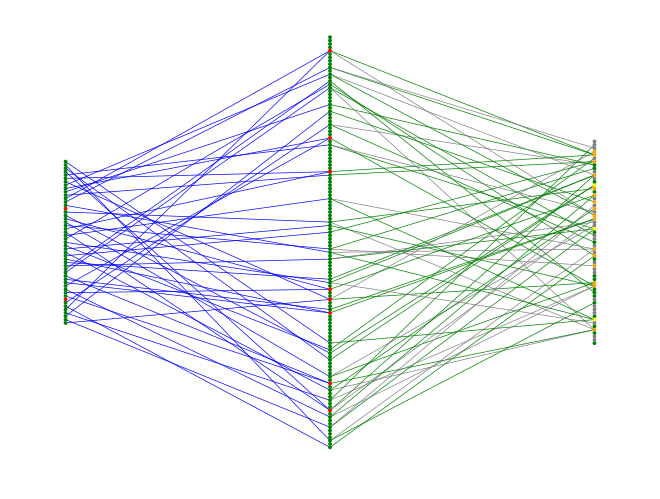

In [175]:

G=nx.Graph()

start_supervisors = len(students)
start_topics = len(students) + len(supervisors)

G.add_nodes_from(students.values(),name='0student')
G.add_nodes_from(supervisors.values(),name='2supervisor')
G.add_nodes_from(topics.values(),name='1topic')

for (i,student) in students.items():
    if student.topic:
        G.add_node(student,name="0 Student",color = "green")
        G.add_edge(student,student.topic,weight=1,color= "blue", preference= j)
    else:
        G.add_node(student,name="0 Student",color = "red")

for (i, supervisor) in supervisors.items():
    if supervisor.affiliation == "Laboratory of Geo-information Science and Remote Sensing":
        if supervisor.student_load()  / supervisor.capacity >1:
            G.add_node(supervisor,name="2 Supervisor",color= "red")
        elif supervisor.student_load()  / supervisor.capacity >0.75:
            G.add_node(supervisor,name="2 Supervisor",color= "orange")
        elif supervisor.student_load()  / supervisor.capacity >0.5:
            G.add_node(supervisor,name="2 Supervisor",color= "yellow")
        else:
            G.add_node(supervisor,name="2 Supervisor",color= "green")
    else:
        G.add_node(supervisor,name="2 Supervisor",color= "grey")
    

for (i,topic) in topics.items():
    if len(topic.final_students)  / topic.capacity >0.95:
        G.add_node(topic,name="1 Topic", color= "red")
    elif len(topic.final_students)  / topic.capacity >0.75:
        G.add_node(topic,name="1 Topic", color= "orange")
    elif len(topic.final_students)  / topic.capacity >0.5:
        G.add_node(topic,name="1 Topic", color= "yellow")
    else:
        G.add_node(topic,name="1 Topic", color= "green")
    if len(topic.final_students)>0:
        G.add_edge(topic,topic.supervisor,weight=1,color= "green", object= topic)
        if topic.cosupervisor:
            G.add_edge(topic,topic.cosupervisor,weight=1,color= "grey", object= topic)

#pos = nx.circular_layout(G)
pos = nx.multipartite_layout(G, subset_key="name")
G_naive = G
nx.draw(G_naive, pos, node_color=nx.get_node_attributes(G_naive,'color').values(),edge_color=nx.get_edge_attributes(G_naive,'color').values(),width=0.5,node_size=3)

## Optimise supervisor load

Currently unused. Visit advisors with low load and check if a student's lower ranking preference for a topic can be assigned to improve the workload of advisors.

In [177]:
for (i,supervisor) in supervisors.items():
    print("Supervisor " + supervisor.name + " has " + str(supervisor.student_load()) + "/" + str(supervisor.capacity) + " students.")
        
    for topic in supervisor.topics:
        print("    Main:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))
    for topic in supervisor.cotopics:
        print("    Co:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))

Supervisor Alvaro Lau Sarmiento has 2/3 students.
    Main:Accuracy of forest regrowth dynamics in the Peruvian Amazon using the AVOCADO algorithm: 1/2
    Main:Individual tree detection and segmentation with Terrestrial Lidar point clouds of tropical forests: 1/2
    Main:Inventory stem map alignment based on T-LiDAR based map: 0/2
    Main:Isolating and estimating volume of agroforestry systems in the Flevopolder: 0/2
Supervisor Jiayan Zhao has 1/5 students.
    Main:Agent-based modeling and simulation of shared space in virtual reality: 1/2
    Main:Augmented reality display on windshields: 0/2
    Main:Eye-tracking in immersive virtual environments: 0/2
    Main:Immersive virtual environments based on open geospatial data: 0/2
    Main:Understanding citizens’ perception of urban densification through virtual reality: 0/2
Supervisor Arend Ligtenberg has 2/5 students.
    Main:Exploring resilience in Socio Ecological Systems: 0/2
    Main:Perception of Places in an Urban context: 0/2

In [93]:
for (i,supervisor) in supervisors.items():
    if supervisor.affiliation == "Laboratory of Geo-information Science and Remote Sensing":
        if supervisor.student_load()  / supervisor.capacity <= 0.75:
            print("Reassigning students optimally...")
            for topic in supervisor.topics:
                print("Supervisor " + supervisor.name + " has " + str(supervisor.student_load()) + "/" + str(supervisor.capacity) + " students.")
                print("    Main:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))
                for j in range(1,4):
                    for student in topic.interested_students[j]:
                        if not student.topic is topic:
                            print("         " + str(j) + " preference for " + student.name + " | current pref used: " + str(student.attained_preference))

                if len(topic.final_students) < topic.capacity:
                    print("             Assigning second preference students ...")
                    len_pref_2 = len(topic.interested_students[2])
                    if (len_pref_2>0):
                        random_idx = 0
                        #print(len_pref_2)
                        if (len_pref_2>1):
                            random_idx = random.sample(range(0, len_pref_2), 1)[0]
                        #print(random_idx)
                        student = topic.interested_students[2][random_idx]

                        if student.topic:
                            if (not student in topic.final_students):
                                #Clear student topic
                                print("             Remove topic " + student.topic.name + " for " + student.name + " ...")
                                student.topic.supervisor.assigned_students.remove(student)
                                if student.topic.cosupervisor:
                                    student.topic.cosupervisor.cosupervised_students.remove(student)
                                student.topic.final_students.remove(student)
        
                                #Assign new topic
                                print("             Assign topic " + topic.name + " for " + student.name + " ...")
                                topic.supervisor.assigned_students.append(student)
                                if topic.cosupervisor:
                                    topic.cosupervisor.cosupervised_students.append(student)
                                student.topic = topic
                                student.attained_preference = 2
                                topic.final_students.append(student)
                                print("             Transfer completed: " + student.topic.name + " for " + student.name )
                            else:
                                print("             Already assigned: " + student.topic.name + " for " + student.name)
                    
                
                if len(topic.final_students) < topic.capacity:
                    print("             Assigning third preference students ...")
                    len_pref_3 = len(topic.interested_students[3])
                    if (len_pref_3>0):
                        random_idx = 0
                        #print(len_pref_3)
                        if (len_pref_2>1):
                            random_idx = random.sample(range(0, len_pref_3), 1)[0]
                        #print(random_idx)
                        student = topic.interested_students[3][random_idx]

                        if student.topic:
                            if (not student in topic.final_students):
                                #Clear student topic
                                print("             Remove topic " + student.topic.name + " for " + student.name + " ...")
                                student.topic.supervisor.assigned_students.remove(student)
                                if student.topic.cosupervisor:
                                    student.topic.cosupervisor.cosupervised_students.remove(student)
                                student.topic.final_students.remove(student)
        
                                #Assign new topic
                                print("             Assign topic " + topic.name + " for " + student.name + " ...")
                                topic.supervisor.assigned_students.append(student)
                                if topic.cosupervisor:
                                    topic.cosupervisor.cosupervised_students.append(student)
                                student.topic = topic
                                student.attained_preference = 2
                                topic.final_students.append(student)
                                print("             Transfer completed: " + student.topic.name + " for " + student.name )
                            else:
                                print("             Already assigned: " + student.topic.name + " for " + student.name)
                    
            for topic in supervisor.cotopics:
                print("    Co:" + topic.name + ": " + str(len(topic.final_students)) + "/" + str(topic.capacity))
                for j in range(1,4):
                    for student in topic.interested_students[j]:
                        if not student.topic is topic:
                            print("         " + str(j) + " preference for " + student.name + " | current pref used: " + str(student.attained_preference))

            

Reassigning students optimally...
Supervisor Alvaro Lau Sarmiento has 2/3 students.
    Main:Accuracy of forest regrowth dynamics in the Peruvian Amazon using the AVOCADO algorithm: 1/1
Supervisor Alvaro Lau Sarmiento has 2/3 students.
    Main:Individual tree detection and segmentation with Terrestrial Lidar point clouds of tropical forests: 1/1
Supervisor Alvaro Lau Sarmiento has 2/3 students.
    Main:Inventory stem map alignment based on T-LiDAR based map: 0/1
             Assigning second preference students ...
             Assigning third preference students ...
Supervisor Alvaro Lau Sarmiento has 2/3 students.
    Main:Isolating and estimating volume of agroforestry systems in the Flevopolder: 0/1
             Assigning second preference students ...
             Assigning third preference students ...
Reassigning students optimally...
Supervisor Jiayan Zhao has 1/5 students.
    Main:Agent-based modeling and simulation of shared space in virtual reality: 1/1
         3 prefere

In [94]:
sap=sum(student.attained_preference for student in students.values())/len(students)
saw=sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors)
print("Student average preference: " + str(sap))
print("Supervisor average workload: " + str(saw))

Student average preference: 1.469387755102041
Supervisor average workload: 0.471584699453552


In [95]:
print(Counter([student.attained_preference for student in students.values()]))
student_len = len(students)
print("Average 1st pref. prob.: " + str(sum(1 if student.attained_preference==1 else 0 for student in students.values())/(student_len)))
print("Average 2nd pref. prob.: " + str(sum(1 if student.attained_preference==2 else 0 for student in students.values())/(student_len)))
print("Average 3nd pref. prob.: " + str(sum(1 if student.attained_preference==3 else 0 for student in students.values())/(student_len)))
print("Student average preference: " + str(sum(student.attained_preference for student in students.values())/len(students)))
print("Supervisor average workload: " + str(sum(supervisor.student_load()/supervisor.capacity for supervisor in supervisors.values())/len(supervisors)))

Counter({2: 23, 1: 16, -1: 5, 3: 5})
Average 1st pref. prob.: 0.32653061224489793
Average 2nd pref. prob.: 0.46938775510204084
Average 3nd pref. prob.: 0.10204081632653061
Student average preference: 1.469387755102041
Supervisor average workload: 0.471584699453552


# Export

Produces csv files of the assignments and the loads on supervisors.

In [180]:
topic_assignments = pd.DataFrame(columns=["Email",
                                          "Name",
                                          "Intended start date of thesis",
                                          "Intended end date of thesis (approximate)",
                                          "choice",
                                          "Assigned topic",
                                          "supervisor",
                                          "supervisor 2",
                                         "First choice",
                                          "1 supervisor",
                                          "1 supervisor 2",
                                          "Second Choice",
                                          "2 supervisor",
                                          "2 supervisor 2",
                                          "Third Choice",
                                          "3 supervisor",
                                          "3 supervisor 2"])

for student in students.values():
    entry = pd.DataFrame.from_dict({
         "Email": [""],
         "Name": [student.name],
         "Intended start date of thesis": [""],
         "Intended end date of thesis (approximate)": [""],
         "choice": [student.attained_preference],
         "Assigned topic": [student.topic.name if student.topic else "NO TOPIC ASSIGNED"],
         "supervisor": [student.topic.supervisor.name if student.topic else ""],
         "supervisor 2": [student.topic.cosupervisor.name if student.topic and student.topic.cosupervisor else ""],
         "First choice": [student.preferences[0].name if student.preferences[0] else "NO TOPIC ASSIGNED"],
         "1 supervisor": [student.preferences[0].supervisor.name if student.preferences[0] else "NO TOPIC ASSIGNED"],
         "1 supervisor 2": [student.preferences[0].cosupervisor.name if student.preferences[0].cosupervisor else ""],
         "Second Choice": [student.preferences[1].name if student.preferences[1] else "NO TOPIC ASSIGNED"],
         "2 supervisor": [student.preferences[1].supervisor.name if student.preferences[1] else "NO TOPIC ASSIGNED"],
         "2 supervisor 2": [student.preferences[1].cosupervisor.name if student.preferences[1].cosupervisor else ""],
         "Third Choice": [student.preferences[2].name if student.preferences[2] else "NO TOPIC ASSIGNED"],
         "3 supervisor": [student.preferences[2].supervisor.name if student.preferences[2] else "NO TOPIC ASSIGNED"],
         "3 supervisor 2": [student.preferences[2].cosupervisor.name if student.preferences[2].cosupervisor else ""]
    })
    
    topic_assignments = pd.concat([topic_assignments, entry], ignore_index=True)

topic_assignments.to_csv("topic_assignments.csv", encoding='utf-8', index=False)

In [159]:
supervisor_load = pd.DataFrame(columns=["Name",
                                        "Load",
                                        "Direct",
                                        "Indirect",
                                        "Capacity"])

for supervisor in supervisors.values():
    entry = pd.DataFrame.from_dict({
         "Name": [supervisor.name],
         "Load": [supervisor.student_load()],
         "Direct": [len(supervisor.assigned_students)],
         "Indirect": [len(supervisor.cosupervised_students)],
         "Capacity": [supervisor.capacity]
    })
    
    supervisor_load = pd.concat([supervisor_load, entry], ignore_index=True)

supervisor_load.to_csv("supervisor_load.csv", encoding='utf-8', index=False)